In [62]:
import re
import spacy
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')
import calendar
from nltk.corpus import wordnet
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.utils import shuffle
from wordcloud import WordCloud
from matplotlib import pyplot as plt

import chart_studio.plotly as py
from plotly import figure_factory as ff
from plotly import express as px
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

init_notebook_mode(connected=True)
cf.go_offline()

### Read Data

In [63]:

df = pd.read_csv('.\Cookbook Reviews.csv')
df.head(2)


,rec_no,rec_cd,rec_nm,cmt_id,user_id,user_nm,user_reput,timestamp,response_no,upvotes,downvotes,ratings,max_rating,comment
0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...


### Data preprocessing

In [64]:
datapoint = df[~(df['ratings']==0)].reset_index(drop=True)
renamed_cols = {
    'rec_nm':'recipe',
    'user_reput': 'user_behavior',
    'response_no': 'comment_response'
}
datapoint.rename(columns=renamed_cols, inplace=True)

datapoint['datetime'] = pd.to_datetime(datapoint['timestamp'], unit='s')
datapoint['year'] =datapoint['datetime'].dt.year

month_dict = {i: calendar.month_name[i][:3] for i in range(1, 13)}
datapoint['month'] = datapoint['datetime'].dt.month#.map(month_dict)

drop_cols = ['rec_cd', 'rec_no', 'cmt_id', 'user_id', 'user_nm', 'timestamp', 'datetime']
datapoint.drop(columns=drop_cols, inplace=True)
datapoint.drop_duplicates(inplace=True)
datapoint.dropna(inplace=True)
datapoint.head()

,recipe,user_behavior,comment_response,upvotes,downvotes,ratings,max_rating,comment,year,month
0,Creamy White Chili,1,0,0,0,5,527,"I tweaked it a little, removed onions because ...",2022,10
1,Creamy White Chili,50,0,7,0,5,724,Bush used to have a white chili bean and it ma...,2022,10
2,Creamy White Chili,10,0,3,0,5,710,I have a very complicated white chicken chili ...,2022,9
3,Creamy White Chili,1,0,3,1,5,518,amazing! my boyfriend loved it so much! going ...,2022,8
4,Creamy White Chili,1,0,11,0,5,833,Wow!!! This recipe is excellent as written!! ...,2022,2


>#### Text polarity

In [65]:
def text_polarity(text):
    return TextBlob(text).sentiment.polarity

def text_sentiment(text):
    score = text_polarity(text)
    if score<0:
        return 'negative'
    elif score==0: 
        return 'neutral'
    else:
        return 'positive'


datapoint['comment'] = datapoint['comment'].astype(str)
datapoint['sentiment'] = datapoint['comment'].apply(text_sentiment)

>#### Data filtering

In [66]:
def filter_votes(datapoint, threshold=3)-> pd.DataFrame:    
    up_voted = shuffle(datapoint[datapoint.upvotes>datapoint.downvotes], random_state=43)
    eq_voted = shuffle(datapoint[datapoint.upvotes==datapoint.downvotes], random_state=43)
    down_voted = shuffle(datapoint[datapoint.upvotes<datapoint.downvotes], random_state=43)
    
    return shuffle(pd.concat(
        [down_voted[down_voted.ratings<=threshold],
         up_voted[up_voted.ratings>threshold],
         eq_voted], axis=0), random_state=3)

def filter_sentiments(datapoint, threshold=3) -> pd.DataFrame:
    lt_threshold = datapoint[datapoint.ratings<=threshold]
    gt_threshold = datapoint[datapoint.ratings>threshold]
    pos_sentiment = shuffle(gt_threshold[~(gt_threshold.sentiment=='negative')], random_state=3)
    neg_sentiment = shuffle(lt_threshold[~(lt_threshold.sentiment=='positive')], random_state=3)
    
    data_frame = shuffle(pd.concat([neg_sentiment, pos_sentiment], axis=0), random_state=3)
    return data_frame

modelpoint = filter_votes(datapoint)
modelpoint = filter_sentiments(modelpoint)
modelpoint = shuffle(modelpoint)
modelpoint.head()

,recipe,user_behavior,comment_response,upvotes,downvotes,ratings,max_rating,comment,year,month,sentiment
3850,Zucchini Pizza Casserole,1,0,0,0,4,100,My son said that it tasted like my homemade pi...,2021,6,positive
14812,Strawberry Pretzel Salad,1,0,0,0,5,100,We have made this for years. Love it with ras...,2021,6,positive
2897,Flavorful Chicken Fajitas,1,0,0,0,5,100,I made this for my picky nieces and they both ...,2021,6,positive
9673,Garlic Beef Enchiladas,1,0,0,0,5,100,These are absolutely delectable. I warmed the...,2021,6,positive
16093,Lime Chicken Tacos,1,0,0,0,5,100,Very good. I cooked for 4.5 hours and meat w...,2021,6,positive


### Data Exploration

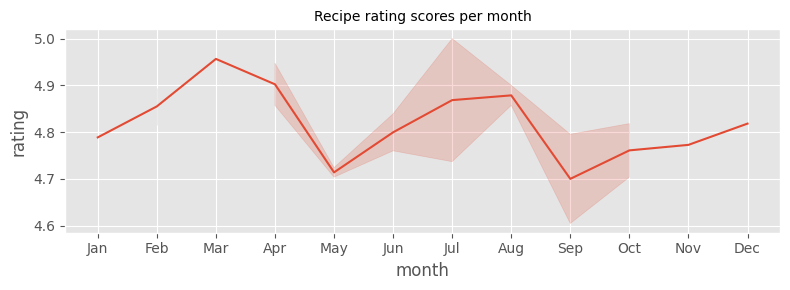

In [67]:
sub_df4 = modelpoint.groupby(['month', 'year'],as_index=False)['ratings'].mean().sort_values('month')
sub_df4.month = sub_df4.month.map(month_dict)
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1, figsize=(8,3))

plt.style.use('ggplot')
filter_by_year = 2021

sns.lineplot(sub_df4, x='month', y='ratings', ax=ax)

ax.set_ylabel('rating')
ax.set_xlabel('month')
ax.set_title('Recipe rating scores per month', fontdict=dict(size=10))
plt.tight_layout()
plt.show()

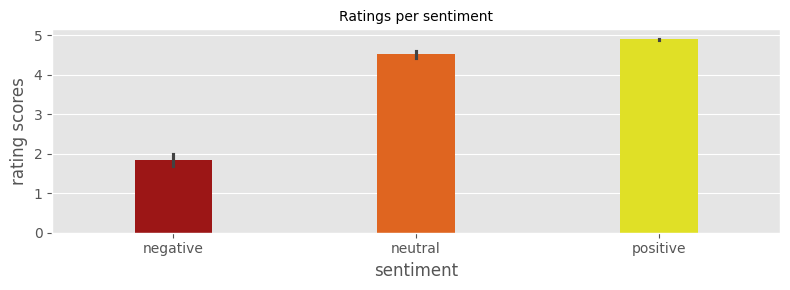

In [68]:
sub_df1 = modelpoint.groupby(['recipe', 'sentiment'], as_index=False)['ratings'].mean()
fig, ax = plt.subplots(1,1, figsize=(8,3))

plt.style.use('ggplot')
# sns.set_palette('plasma')
sns.barplot(sub_df1, y='ratings', x='sentiment', palette='hot', hue='sentiment', ax=ax, gap=0.6)

ax.set_ylabel('rating scores')
# ax.set_xlabel('Sentiment')
ax.set_title('Ratings per sentiment', fontdict=dict(size=10))
plt.tight_layout()
plt.show()


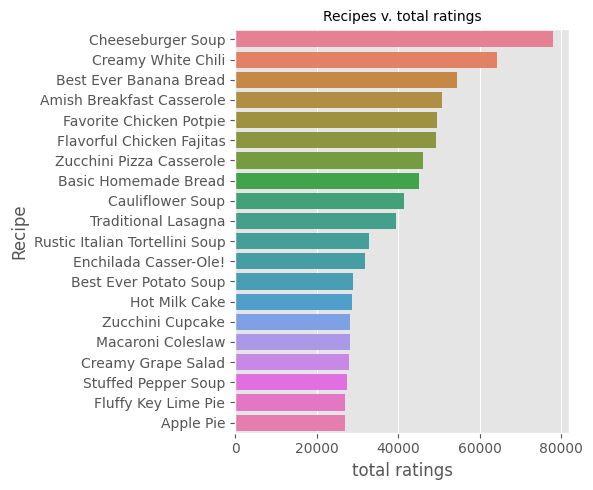

In [69]:
recipe_df = modelpoint.groupby(['recipe'], as_index=False)['max_rating'].sum().sort_values('max_rating', ascending=False).reset_index(drop=True)
fig, ax = plt.subplots(1,1, figsize=(6,5))

plt.style.use('ggplot')
# sns.set_palette('')
sns.barplot(recipe_df.iloc[:20], x='max_rating', y='recipe', hue='recipe', ax=ax)

ax.set_ylabel('Recipe')
ax.set_xlabel('total ratings')
ax.set_title('Recipes v. total ratings', fontdict=dict(size=10))
plt.tight_layout()
plt.show()

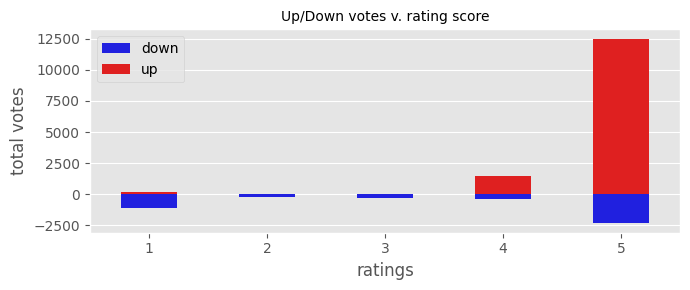

In [70]:
up_votes = modelpoint.groupby('ratings')['upvotes'].sum()
down_votes = modelpoint.groupby('ratings')['downvotes'].sum()
res_comments = modelpoint.groupby('ratings')['comment_response'].sum()
res_votes = pd.merge(up_votes, down_votes, how='inner', on='ratings').merge(res_comments, on='ratings', how='inner').reset_index(drop=False)
res_votes= res_votes.sort_values('ratings', ascending=False)
res_votes['downvotes'] = res_votes['downvotes'].map(lambda value: -value)
fig, ax = plt.subplots(1,1, figsize=(7,3))

plt.style.use('ggplot')
sns.barplot(res_votes, x='ratings', y='downvotes', color='blue', gap=0.4,ax=ax, label='down')
sns.barplot(res_votes, x='ratings', y='upvotes', color='red', gap=0.4, ax=ax, label='up')
plt.ylabel('total votes')
plt.title('Up/Down votes v. rating score', fontdict=dict(size=10))
plt.tight_layout()
plt.show()


In [90]:
modelpoint.head()

,recipe,user_behavior,comment_response,upvotes,downvotes,ratings,max_rating,comment,year,month,sentiment
3850,Zucchini Pizza Casserole,1,0,0,0,4,100,My son said that it tasted like my homemade pi...,2021,6,positive
14812,Strawberry Pretzel Salad,1,0,0,0,5,100,We have made this for years. Love it with ras...,2021,6,positive
2897,Flavorful Chicken Fajitas,1,0,0,0,5,100,I made this for my picky nieces and they both ...,2021,6,positive
9673,Garlic Beef Enchiladas,1,0,0,0,5,100,These are absolutely delectable. I warmed the...,2021,6,positive
16093,Lime Chicken Tacos,1,0,0,0,5,100,Very good. I cooked for 4.5 hours and meat w...,2021,6,positive


[(5, 12685), (4, 1386), (3, 93), (2, 68), (1, 140)]

In [195]:
def compute_distrited_values(colname):
    ratings = sorted(modelpoint[colname].value_counts().to_dict().items(), key=lambda item: item[0], reverse=True)
    values = [w for _, w in ratings]
    labels = [w for w, _ in ratings]
    tot = sum(values)
    annot_labels =['{} - {:,.2f}%'.format(v, (w/tot)*100) for w,v in zip(values, labels)]
    return values, annot_labels

In [224]:
def distribution_chart(values, labels, title):
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    plt.style.use('ggplot')
    pie = ax.pie(x=values, counterclock=False, startangle=-270, wedgeprops={
        'width':0.5, 'edgecolor':'white', 'linewidth': 2})
    ax.set_title(f'{title} distributions', fontsize='11')
    plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc='center right', bbox_transform=plt.gcf().transFigure)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


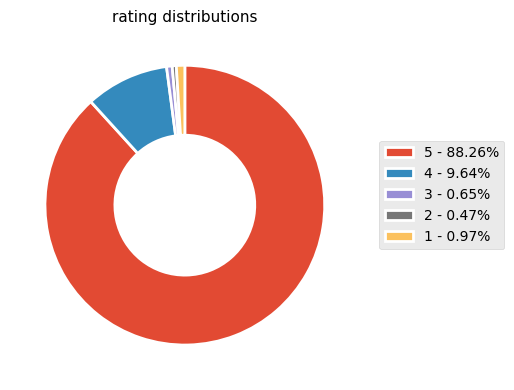

In [223]:
values, labels = compute_distrited_values('ratings')
title = 'rating'
distribution_chart(values, labels, title)

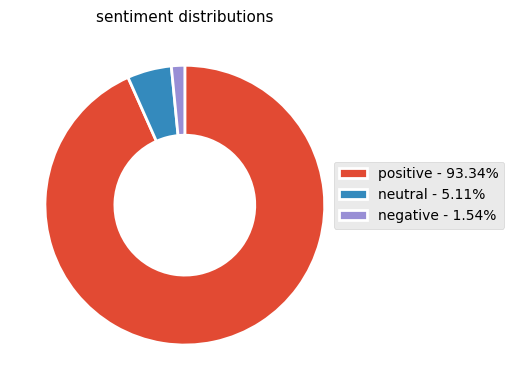

In [208]:
values, labels = compute_distrited_values('sentiment')
title = 'sentiment'

distribution_chart(values, labels, title)

In [220]:
#Upvotes & Downvotes plot
def up_down_vote_plot(ax):
    up_votes = modelpoint.groupby('ratings')['upvotes'].sum()
    down_votes = modelpoint.groupby('ratings')['downvotes'].sum()
    res_comments = modelpoint.groupby('ratings')['comment_response'].sum()
    res_votes = pd.merge(up_votes, down_votes, how='inner', on='ratings').merge(res_comments, on='ratings', how='inner').reset_index(drop=False)
    res_votes= res_votes.sort_values('ratings', ascending=False)
    res_votes['downvotes'] = res_votes['downvotes'].map(lambda value: -value)


    sns.barplot(res_votes, x='ratings', y='downvotes', color='blue', gap=0.4,ax=ax, label='down')
    sns.barplot(res_votes, x='ratings', y='upvotes', color='red', gap=0.4, ax=ax, label='up')
    ax.set_ylabel('total votes', fontdict=dict(size=10))
    ax.set_xlabel('total votes', fontdict=dict(size=10))
    ax.set_title('Up/Down votes v. rating score', fontdict=dict(size=10))

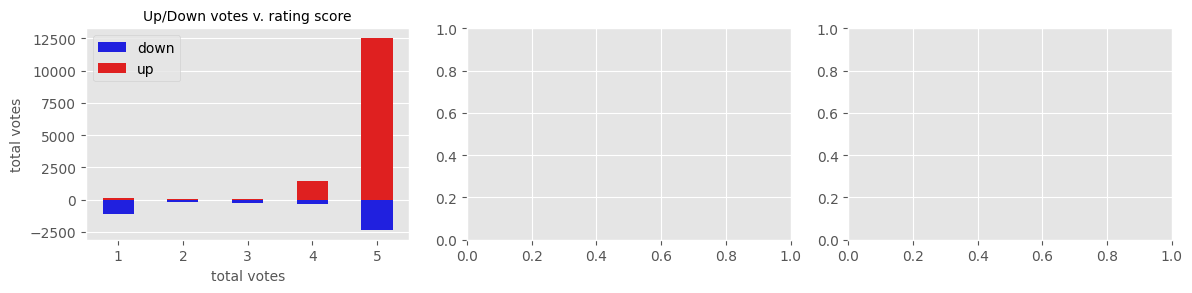

In [221]:
# nrows = 
plt.figure(figsize=(12,8))
plt.style.use('ggplot')
ax1 = plt.subplot2grid((3,3),(0,0))
ax2 = plt.subplot2grid((3,3),(0,1))
ax3 = plt.subplot2grid((3,3),(0,2))

up_down_vote_plot(ax1)
plt.tight_layout()
plt.show()

In [71]:
ratings_prop = modelpoint.ratings.value_counts(normalize=True).to_frame().reset_index()
# ratings_prop.head()
fig = px.pie(data_frame=ratings_prop,values='proportion',
             names='ratings', hole=0.4, width=800, height=300
             )
fig.update_layout(title='Rating distribution')
fig.update_legends(title='Ratings', )

In [72]:
ratings_prop = modelpoint.sentiment.value_counts(normalize=True).to_frame().reset_index()
# ratings_prop.head()
fig = px.pie(data_frame=ratings_prop,values='proportion',
             names='sentiment', hole=0.4, width=800, height=300,
             color_discrete_sequence=px.colors.sequential.RdBu_r
             )
fig.update_layout(title='Sentiment distribution')
fig.update_legends(title='Ratings', )

In [73]:
stop_words = np.unique(list(ENGLISH_STOP_WORDS) + stopwords.words('english'))
lemma = WordNetLemmatizer()

model_point= modelpoint[['ratings', 'sentiment','comment']].dropna().copy()
model_point.head()

,ratings,sentiment,comment
3850,4,positive,My son said that it tasted like my homemade pi...
14812,5,positive,We have made this for years. Love it with ras...
2897,5,positive,I made this for my picky nieces and they both ...
9673,5,positive,These are absolutely delectable. I warmed the...
16093,5,positive,Very good. I cooked for 4.5 hours and meat w...


In [74]:
# text-preprocessing methods
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][1].upper()
    tag_list = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_list.get(tag, wordnet.NOUN)

nlp_model = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def text_processor(s: str) -> str:
    text = s.lower()
    text = contractions.fix(text)
    text = ' '.join([word.strip() for word in re.findall(r'\w+',text)])
    text = re.sub(r'\d+', '', text)
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    # text = ' '.join([lemma.lemmatize(word, pos=get_wordnet_pos(word)) for word in text.split()])
    text = ' '.join([token.lemma_ for token in nlp_model(text)])
    text = ' '.join([word for word in text.split() if len(word)>2])
    return text

model_point['comment'] = model_point['comment'].astype(str)
model_point['clean_comment'] = model_point['comment'].map(text_processor)
model_point['tokens'] = model_point['clean_comment'].map(lambda s: s.split())
model_point.head()

,ratings,sentiment,comment,clean_comment,tokens
3850,4,positive,My son said that it tasted like my homemade pi...,son say taste like homemade pizza know zucchin...,"[son, say, taste, like, homemade, pizza, know,..."
14812,5,positive,We have made this for years. Love it with ras...,year love raspberry gelatin tangy raspberry,"[year, love, raspberry, gelatin, tangy, raspbe..."
2897,5,positive,I made this for my picky nieces and they both ...,picky niece love easy make,"[picky, niece, love, easy, make]"
9673,5,positive,These are absolutely delectable. I warmed the...,absolutely delectable warmed flour tortillas c...,"[absolutely, delectable, warmed, flour, tortil..."
16093,5,positive,Very good. I cooked for 4.5 hours and meat w...,good cooked hour meat start dry time check hou...,"[good, cooked, hour, meat, start, dry, time, c..."


>#### Text distributions

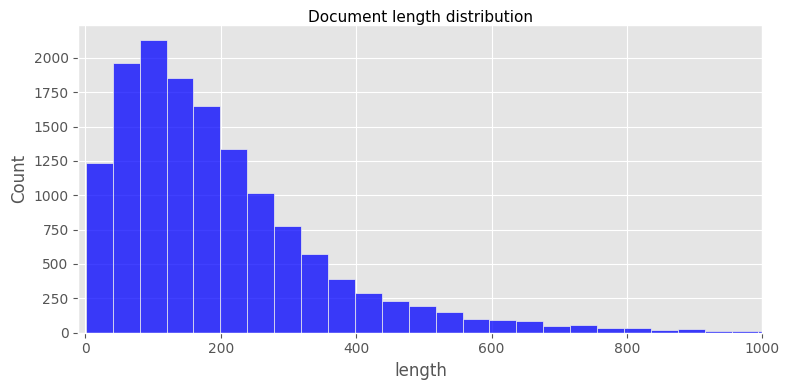

In [75]:
review_length = [len(x) for x in modelpoint['comment']]
fig, ax = plt.subplots(1, 1, figsize=(8,4))

sns.histplot(x=review_length, binwidth=40, color='blue')
plt.title('Document length distribution', fontdict=dict(size=11, weight='light'), pad=0.8)
plt.xlim(-10, 1000)
plt.xlabel('length')
plt.tight_layout()
plt.show()

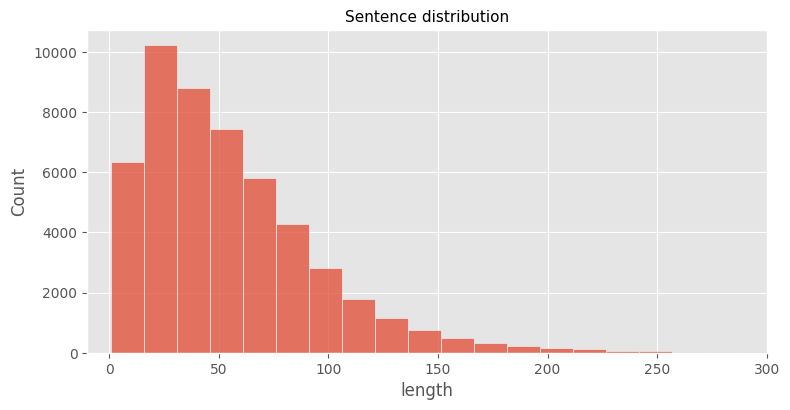

In [76]:
sentence_level = [sentence for doc in model_point['comment'] for sentence in sent_tokenize(doc,'english')]
sentence_length = [len(sent) for sent in sentence_level]
fig, ax = plt.subplots(1, 1, figsize=(8,4))

sns.histplot(x=sentence_length, binwidth=15)

plt.xlim(-10, 300)
plt.xlabel('length')
plt.tight_layout()
plt.title('Sentence distribution', fontdict=dict(size=11, weight='light'))
plt.show()

In [77]:
pos_modelpoint = model_point[model_point['sentiment']=='positive']
ne_modelpoint = model_point[model_point['sentiment']=='neutral']
neg_modelpoint = model_point[model_point['sentiment']=='negative']

In [78]:
sorted_pos = sorted({word: index+1 for tokens in pos_modelpoint['tokens'] for index, word in enumerate(tokens)}.items(), key=lambda item: item[1], reverse=True)
sorted_neg = sorted({word: index+1 for tokens in neg_modelpoint['tokens'] for index, word in enumerate(tokens)}.items(), key=lambda item: item[1], reverse=True)
sorted_ne = sorted({word: index+1 for tokens in ne_modelpoint['tokens'] for index, word in enumerate(tokens)}.items(), key=lambda item: item[1], reverse=True)

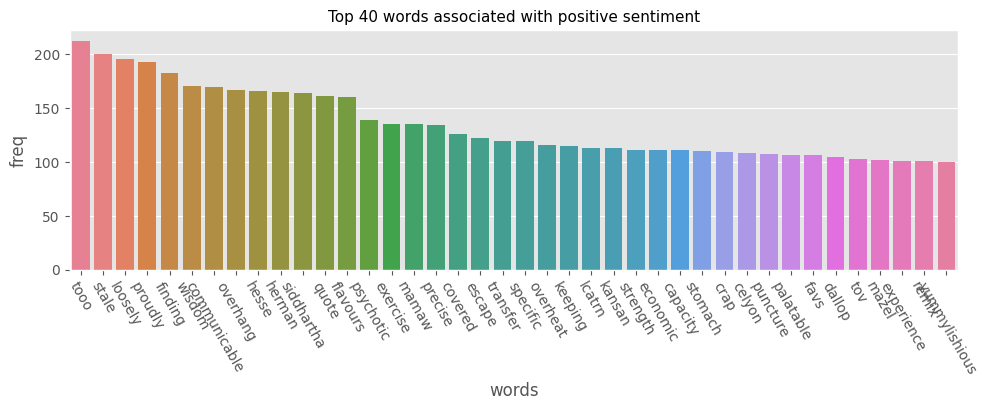

In [79]:
def plot_sentiment_words(words: list[str],sentiment_title: str, topn=40):
    x = [i for i, _ in words[:topn]]
    y = [i for _,i in words[:topn]]
    
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    sns.barplot(x=x, y=y, hue=x, ax=ax)

    plt.xticks(rotation=-60)
    plt.xlabel('words')
    plt.ylabel('freq')
    plt.tight_layout()
    plt.title(f'Top {topn} words associated with {sentiment_title} sentiment', fontdict=dict(size=11, weight='light'))
    plt.show()
    
plot_sentiment_words(sorted_pos, 'positive')

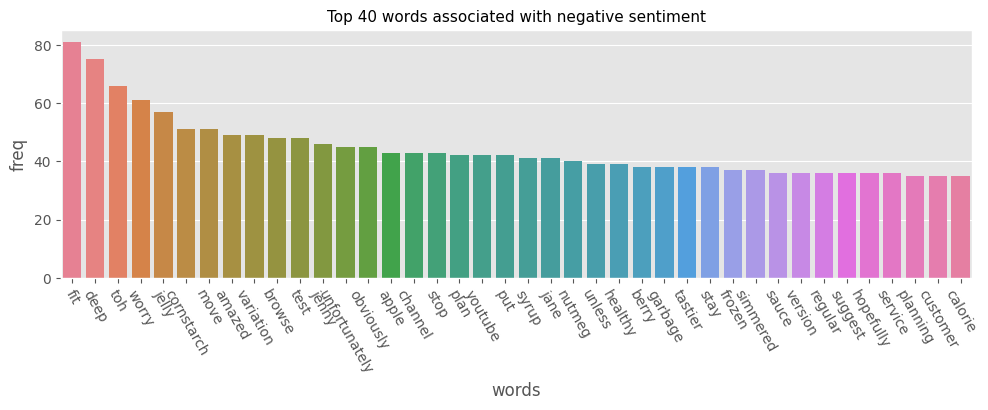

In [80]:
plot_sentiment_words(sorted_neg, 'negative')

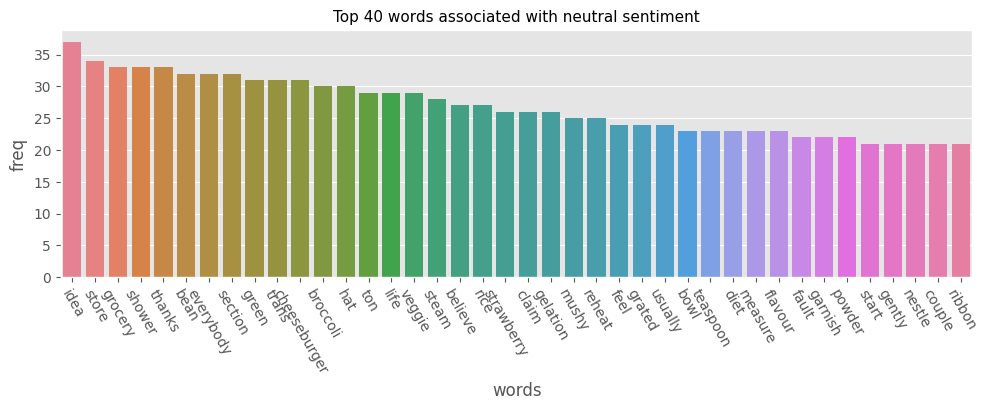

In [81]:
plot_sentiment_words(sorted_ne, 'neutral')

In [82]:
stars_4_to_5 = model_point[(model_point['ratings']==4) | (model_point['ratings']==5)]

stars_1_to_3 = model_point[(model_point['ratings']==1) |
                           (model_point['ratings']==3) |
                           (model_point['ratings']==3)]


sorted_4_to_5 = sorted({word: index+1 for tokens in stars_4_to_5['tokens'] for index, word in enumerate(tokens)}.items(), key=lambda item: item[1], reverse=True)
sorted_1_to_3 = sorted({word: index+1 for tokens in stars_1_to_3['tokens'] for index, word in enumerate(tokens)}.items(), key=lambda item: item[1], reverse=True)


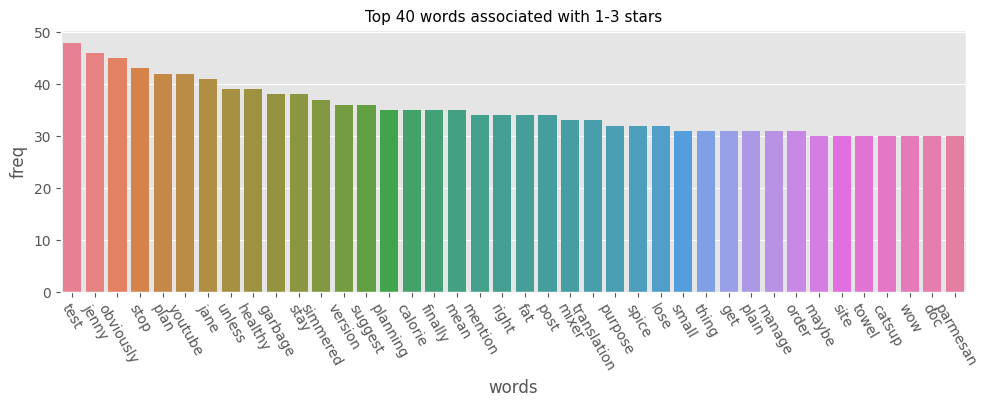

In [83]:
def plot_sentiment_words(words: list[str],rating_range: str, topn=40):
    x = [i for i, _ in words[:topn]]
    y = [i for _,i in words[:topn]]
    
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    sns.barplot(x=x, y=y, hue=x, ax=ax)

    plt.xticks(rotation=-60)
    plt.xlabel('words')
    plt.ylabel('freq')
    plt.tight_layout()
    plt.title(f'Top {topn} words associated with {rating_range} stars', fontdict=dict(size=11, weight='light'))
    plt.show()
    
plot_sentiment_words(sorted_1_to_3, '1-3')

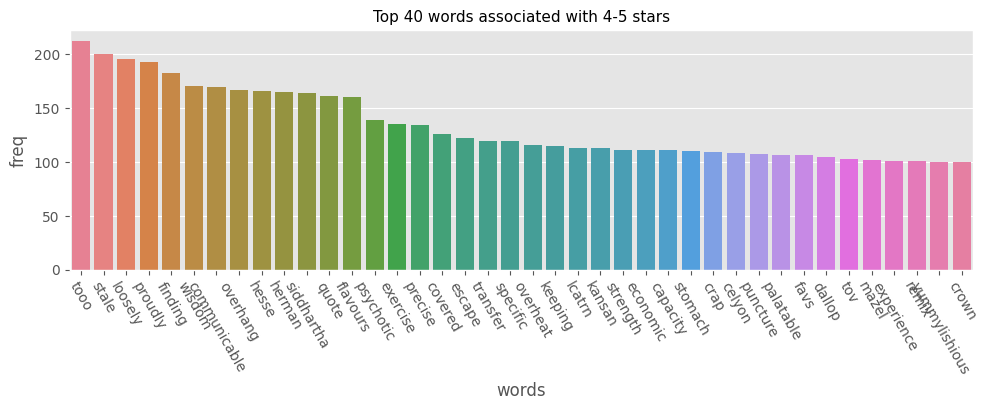

In [84]:
plot_sentiment_words(sorted_4_to_5, '4-5')

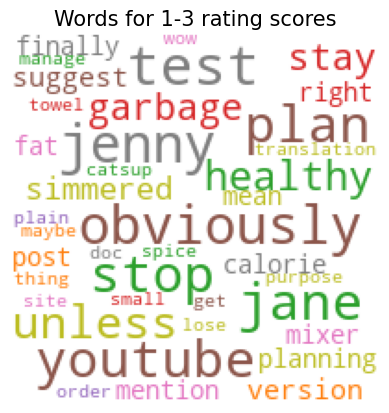

In [85]:
def cloud_plot(sorted_words, title):
    word_cloud = WordCloud(
        stopwords=stop_words,
        background_color='white',
        max_font_size=30,
        max_words=40,
        colormap='tab10',
        width=200,
        height=200,
        random_state=42,
        prefer_horizontal=1,
        min_font_size=10
    )

    word_cloud.generate_from_frequencies(dict(sorted_words))
    plt.imshow(word_cloud)
    plt.title(f'{title}', fontdict=dict(size=15, weight='light'))
    plt.axis('off')
    plt.show()
    
cloud_plot(sorted_1_to_3, 'Words for 1-3 rating scores')

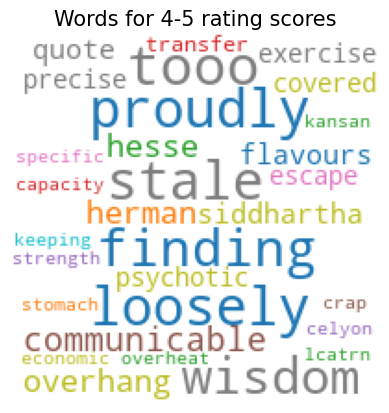

In [86]:
cloud_plot(sorted_4_to_5, 'Words for 4-5 rating scores')

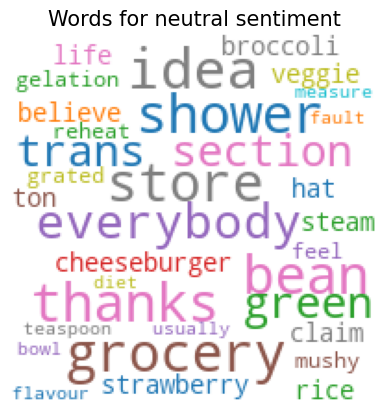

In [87]:
cloud_plot(sorted_ne, 'Words for neutral sentiment')

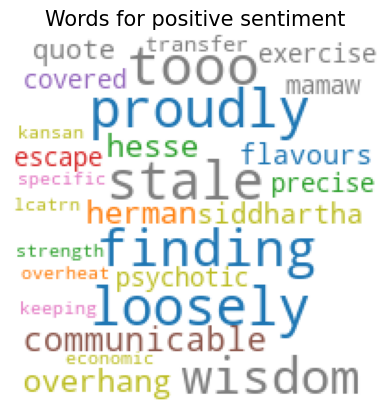

In [88]:
cloud_plot(sorted_pos, 'Words for positive sentiment')

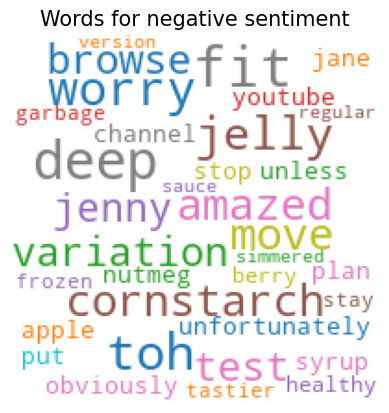

In [89]:
cloud_plot(sorted_neg, 'Words for negative sentiment')